## Example: Face Recognition
- Faces images are all pre cropped into nice pixels
- Each image contains [62×47] or nearly 3,000 pixels
- The real facial classification scheme is the feature selection: Use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation
####  <font color='red'>--PCA(whiten) </font>
http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/
- We have used PCA to reduce the dimension of the data. There is a closely related preprocessing step called whitening (or, in some other literatures, sphering) which is needed for some algorithms. If we are **training on images**, the raw input is redundant, since **adjacent pixel values are highly correlated**. The goal of whitening is to make the input less redundant; more formally, our desiderata are that our learning algorithms sees a training input where **(i) the features are less correlated with each other, and (ii) the features all have the same variance**.
- Reason for transposed confusion matrix in heatmap:https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap



In [77]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()


In [118]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

In [79]:
print (faces.target_names)
print (faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


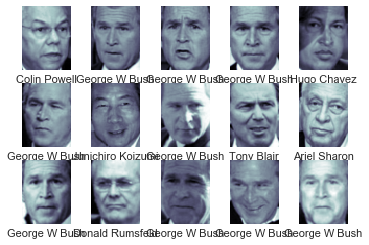

In [119]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])
    

In [120]:
from sklearn.svm import SVC # choose classification
from sklearn.decomposition import PCA # choose preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold # split train/test data
from sklearn.pipeline import make_pipeline # Make pipline
from sklearn.metrics import classification_report, confusion_matrix # Evaluate

from sklearn.grid_search import GridSearchCV

In [153]:
# train / test data
X_train, X_test, y_train, y_test = train_test_split(faces.data,faces.target,random_state=33)
kfold = StratifiedKFold(5)
cv = kfold.get_n_splits(X_train,y_train)

In [154]:
svm = SVC() # Instantiate classification and select hyperparameters 
pca = PCA(n_components=150, whiten=True) # select hyperparameters 
model = make_pipeline(pca,svm) # model

In [156]:
paras = [0.001,0.01,0.1,10]
param_para = [{'svc__gamma':paras,'svc__C':paras,'svc__kernel':['rbf']},
              {'svc__gamma':paras,'svc__C':paras,'svc__kernel':['linear']}]
grid_obj = GridSearchCV(model,param_grid=param_para,cv=cv)
#grid_obj.get_params().keys()

In [157]:
# Train model
%time grid_obj.fit(X_train,y_train)

Wall time: 1min 34s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'svc__kernel': ['rbf'], 'svc__gamma': [0.001, 0.01, 0.1, 10], 'svc__C': [0.001, 0.01, 0.1, 10]}, {'svc__kernel': ['linear'], 'svc__gamma': [0.001, 0.01, 0.1, 10], 'svc__C': [0.001, 0.01, 0.1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [158]:
print ("Best Parameters: ", grid_obj.best_params_)

Best Parameters:  {'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 10}


In [159]:
# Prediction
model_best = grid_obj.best_estimator_
yfit = model_best.predict(X_test)

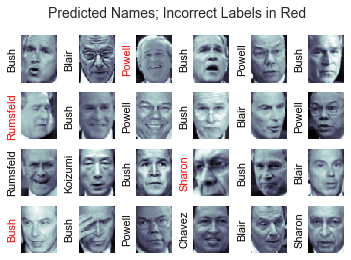

In [160]:
# Evaluation
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [161]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.85      0.83        20
     Colin Powell       0.85      0.86      0.85        58
  Donald Rumsfeld       0.76      0.87      0.81        30
    George W Bush       0.90      0.90      0.90       132
Gerhard Schroeder       0.83      0.75      0.79        32
      Hugo Chavez       0.83      0.83      0.83        12
Junichiro Koizumi       1.00      0.91      0.95        11
       Tony Blair       0.85      0.81      0.83        42

      avg / total       0.86      0.86      0.86       337



In [177]:
mat = confusion_matrix(y_test,yfit)
mat

array([[ 17,   1,   1,   0,   1,   0,   0,   0],
       [  2,  50,   0,   4,   0,   0,   0,   2],
       [  1,   0,  26,   2,   1,   0,   0,   0],
       [  0,   4,   5, 119,   2,   1,   0,   1],
       [  0,   2,   0,   2,  24,   1,   0,   3],
       [  0,   1,   0,   1,   0,  10,   0,   0],
       [  0,   1,   0,   0,   0,   0,  10,   0],
       [  1,   0,   2,   4,   1,   0,   0,  34]], dtype=int64)

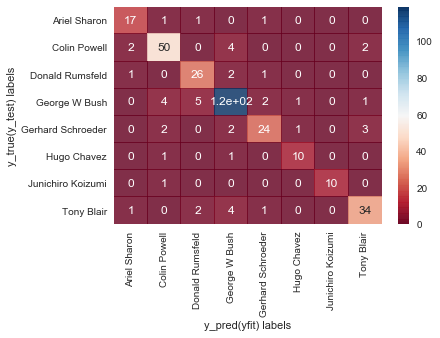

In [188]:
sns.heatmap(mat,cmap="RdBu",alpha=0.8,annot=True,xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel("y_pred(yfit) labels")
plt.ylabel("y_true(y_test) labels")

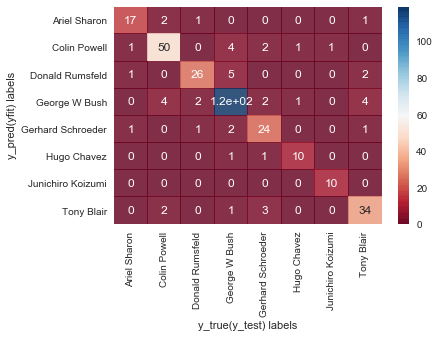

In [189]:
sns.heatmap(mat.T,cmap="RdBu",alpha=0.8,annot=True,xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel("y_true(y_test) labels")
plt.ylabel("y_pred(yfit) labels")